In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

2022-08-02 11:42:35.488265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-02 11:42:35.488281: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:

class faceclassmodel():
    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.model = keras.models.load_model("./facemodel/facenet_keras.h5")
        # self.optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
        print("Model Loaded. Compiling Manually ...")
        self.model.compile()
        # print(self.model.summary())

    def gimme_embeddings(self, imagedata):
        if type(imagedata) == str:
          imagedata = cv2.imread(imagedata)
        img = cv2.resize(imagedata, (160,160), interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        m = img.mean()
        s = img.std()
        x = np.expand_dims((img-m)/s, axis=0)
        images = np.vstack([x])
        emb = self.model.predict(images)
        return  emb

    def face_embeddings(self, imagedata, showfaces = True):
        if type(imagedata) == str:
          imagedata = cv2.imread(imagedata)
        img = cv2.resize(imagedata, (512,512), interpolation=cv2.INTER_AREA)
        imgcopy = np.copy(img)
        faces = self.detect_face(img)
        embs = []
        for (x,y,w,h) in faces:
          embs.append(self.gimme_embeddings(imgcopy[y:y+h, x:x+w]))
          cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        if showfaces:
          plt.figure()
          plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        return img, faces, embs

    def detect_face(self, imagedata):
        if type(imagedata) == str:
          imagedata = cv2.imread(imagedata)
        img = cv2.resize(imagedata, (512,512), interpolation=cv2.INTER_AREA)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.3, 5, 0 )
        return faces

    def plot_faces(self, imagedata):
        if type(imagedata) == str:
          imagedata = cv2.imread(imagedata)
        img = cv2.resize(imagedata, (512,512), interpolation=cv2.INTER_AREA)
        faces = self.detect_face(img)
        for (x,y,w,h) in faces:
          cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        # cv2_imshow(img)


    def train_model(self, train_data, validation_data, epochs):
        history = self.model.fit(
                  train_data,
                  epochs=epochs,
                  verbose=1,
                  validation_data=validation_data )
        return history





facemodel = faceclassmodel()

2022-08-02 11:42:41.201297: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-02 11:42:41.201321: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (prajwal): /proc/driver/nvidia/version does not exist
2022-08-02 11:42:41.201498: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model Loaded. Compiling Manually ...


In [4]:
def compare_embeddings(emb1, emb2):
    return np.linalg.norm(emb1-emb2)

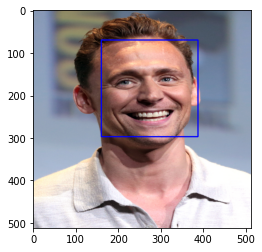

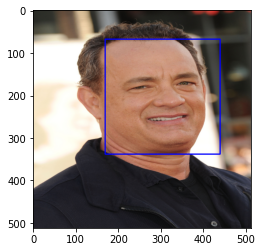

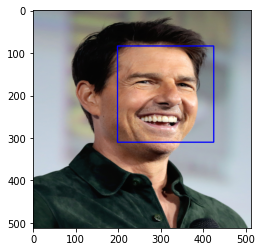

In [5]:
# for all files in dataset
dataset_path = "./dataset"
embs = []
for dirs in os.listdir(dataset_path):
    # for first file in dirs
    # list image files
    for file in os.listdir(dataset_path+"/"+dirs):
        if file.endswith(".jpg"):
            imgfilepath = dataset_path+"/"+dirs+"/"+file
            _, _, emb1 = facemodel.face_embeddings(imgfilepath, showfaces=True)
            break
    # save emb1 to file
    np.save(dataset_path + "/" + dirs + "/" + "emb1.npy", emb1[0])
    embs.append((dirs,emb1[0]))
    # print(emb1)


hiddleston1.jpg
hiddleston2.jpg
hanks1.jpg
hanks2.jpg
cruise1.jpg
cruise2.jpg


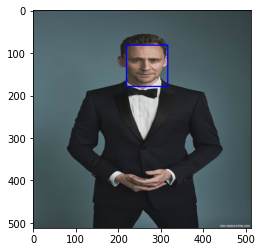

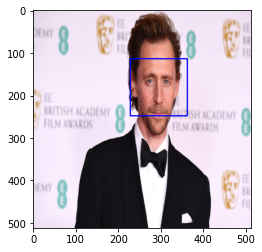

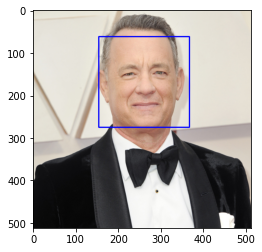

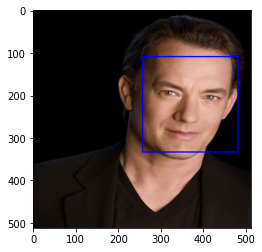

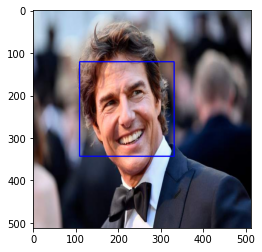

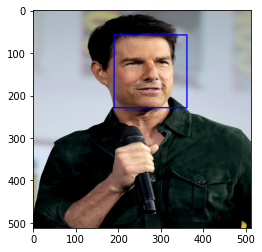

In [6]:
# for all files in dataset
dataset_path = "./dataset"
embstest = []
for dirs in os.listdir(dataset_path):
    # inside the test folder of dirs
    for file in os.listdir(dataset_path+"/"+dirs+"/test"):
        if file.endswith(".jpg"):
            print(file)
            imgfilepath = dataset_path+"/"+dirs+"/test/"+file
            _, _, emb1 = facemodel.face_embeddings(imgfilepath, showfaces=True)
            embstest.append((dirs,emb1[0]))
            # break

    # print(emb1)

In [7]:
print(" "*13 + str([i[0] + " "*(8-len(i[0])) for i in embs]))
for i in range(len(embstest)):
    second = embstest[i]
    second_name = second[0] + " "*(12-len(second[0]))
    print( second_name , [ str(compare_embeddings(first[1][0],second[1][0])).zfill(9) for first in embs ] )
    # for second embeddings(first[1][0],second[1][0]))

             ['Hiddleston', 'Hanks   ', 'Cruise  ']
Hiddleston   ['07.960274', '14.643256', '019.45762']
Hiddleston   ['7.4735126', '15.253132', '17.858438']
Hanks        ['015.59501', '6.4389586', '17.468025']
Hanks        ['15.435329', '09.009986', '16.515615']
Cruise       ['17.634373', '15.739778', '09.027615']
Cruise       ['017.82665', '15.896665', '04.765111']


In [8]:
threshold = 12.0
dataset_path = "./dataset"
savedembs = []
for dirs in os.listdir(dataset_path):
    for file in os.listdir(dataset_path+"/"+dirs):
        if file.endswith("emb1.npy"):
            emb1 = np.load(dataset_path+"/"+dirs+"/"+file)
            savedembs.append((dirs,emb1[0]))


def find_match(imagedata):
    if type(imagedata) == str:
      imagedata = plt.imread(imagedata)
    _,_,thisemb = facemodel.face_embeddings(imagedata, showfaces=False)
    for first in savedembs:
        first_name = first[0]
        differences = compare_embeddings(thisemb,first[1])
        if  differences < threshold:
            return first_name, differences

In [9]:

for dirs in os.listdir(dataset_path):
    fold = "/home/prajwal/Workfolder/FClassifier/dataset"+"/"+dirs+"/test/"
    image = plt.imread([fold+i for i in os.listdir(fold) if i.endswith(".jpg")][0])
    dir_name = dirs + " "*(12-len(dirs))
    print( dir_name , [ find_match(image) ] )
    # for second embeddings(first[1][0],second[1][0]))

Hiddleston   [('Hiddleston', 8.775699)]
Hanks        [('Hanks', 7.17894)]
Cruise       [('Cruise', 10.09772)]
